In [4]:
import pandas as pd
import duckdb

In [ ]:
import pandas as pd
import streamlit as st
import duckdb
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pmdarima import auto_arima

def load_data():
    con = duckdb.connect(database=':memory:', read_only=False)
    path=r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\Sampled_Data\combined_sampled_data.parquet"
    df = con.execute(f"SELECT * FROM '{path}'").df()
    return df
data = load_data()


In [6]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
data=data[data['total_amount']>0]
data=data[data['trip_distance']<=100]

In [8]:
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,23.30,2.50,0.5,5.45,0.0,1.0,32.75,2.5,0.0,0.00
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,NaN,1.26,NaN,None,41,75,0,13.58,0.00,0.5,3.02,0.0,1.0,18.10,NaN,NaN,0.00
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,13.50,0.00,0.5,0.00,0.0,1.0,18.25,2.5,0.0,0.75
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,10.70,2.50,0.5,0.00,0.0,1.0,17.95,2.5,0.0,0.75
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,7.90,0.00,0.5,2.82,0.0,1.0,12.22,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023615,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,5.80,4.25,0.5,2.30,0.0,1.0,13.85,2.5,0.0,0.75
4023616,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,5.80,2.50,0.5,0.00,0.0,1.0,9.80,2.5,0.0,0.00
4023617,2,2025-10-21 20:24:52,2025-10-21 21:02:30,NaN,6.68,NaN,None,107,238,0,-2.88,0.00,0.5,0.00,0.0,1.0,7.23,NaN,NaN,0.75
4023618,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,19.10,0.00,0.5,4.12,0.0,1.0,24.72,0.0,0.0,0.00


In [9]:
data['Date']=data['tpep_pickup_datetime'].dt.date
data['Hour']=data['tpep_pickup_datetime'].dt.hour

In [10]:
data.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
cbd_congestion_fee              float64
Date                             object
Hour                              int32
dtype: object

In [11]:
data['Date']=pd.to_datetime(data['Date'])

In [12]:
data=data[(data['Date'].dt.year)==2025]

In [13]:
resampling = data.groupby(['Date','Hour']).size().reset_index()

In [14]:
resampling

,Date,Hour,0
0,2025-01-01,0,694
1,2025-01-01,1,814
2,2025-01-01,2,656
3,2025-01-01,3,417
4,2025-01-01,4,271
...,...,...,...
7290,2025-10-31,19,1155
7291,2025-10-31,20,1041
7292,2025-10-31,21,1089
7293,2025-10-31,22,1072


In [15]:
resampling =resampling.rename(columns={0:'Trips'})

In [16]:
january = resampling[resampling['Date'].dt.month==1]

In [17]:
january

,Date,Hour,Trips
0,2025-01-01,0,694
1,2025-01-01,1,814
2,2025-01-01,2,656
3,2025-01-01,3,417
4,2025-01-01,4,271
...,...,...,...
739,2025-01-31,19,1013
740,2025-01-31,20,734
741,2025-01-31,21,691
742,2025-01-31,22,869


In [18]:
resampling['Date & Time']=(resampling['Date']+pd.to_timedelta(resampling['Hour'],unit='h'))

In [19]:
resampling

,Date,Hour,Trips,Date & Time
0,2025-01-01,0,694,2025-01-01 00:00:00
1,2025-01-01,1,814,2025-01-01 01:00:00
2,2025-01-01,2,656,2025-01-01 02:00:00
3,2025-01-01,3,417,2025-01-01 03:00:00
4,2025-01-01,4,271,2025-01-01 04:00:00
...,...,...,...,...
7290,2025-10-31,19,1155,2025-10-31 19:00:00
7291,2025-10-31,20,1041,2025-10-31 20:00:00
7292,2025-10-31,21,1089,2025-10-31 21:00:00
7293,2025-10-31,22,1072,2025-10-31 22:00:00


In [20]:
january = resampling[resampling['Date'].dt.month==1]

In [21]:
january

,Date,Hour,Trips,Date & Time
0,2025-01-01,0,694,2025-01-01 00:00:00
1,2025-01-01,1,814,2025-01-01 01:00:00
2,2025-01-01,2,656,2025-01-01 02:00:00
3,2025-01-01,3,417,2025-01-01 03:00:00
4,2025-01-01,4,271,2025-01-01 04:00:00
...,...,...,...,...
739,2025-01-31,19,1013,2025-01-31 19:00:00
740,2025-01-31,20,734,2025-01-31 20:00:00
741,2025-01-31,21,691,2025-01-31 21:00:00
742,2025-01-31,22,869,2025-01-31 22:00:00


In [22]:
zero_data = january[january['Trips']==0]
zero_data

,Date,Hour,Trips,Date & Time


In [23]:
week_1 = january[january['Date'].dt.day<=7]

In [24]:
january['Trips'].min()

13

In [25]:
resampling['naive_forecast'] = resampling['Trips'].shift(24)

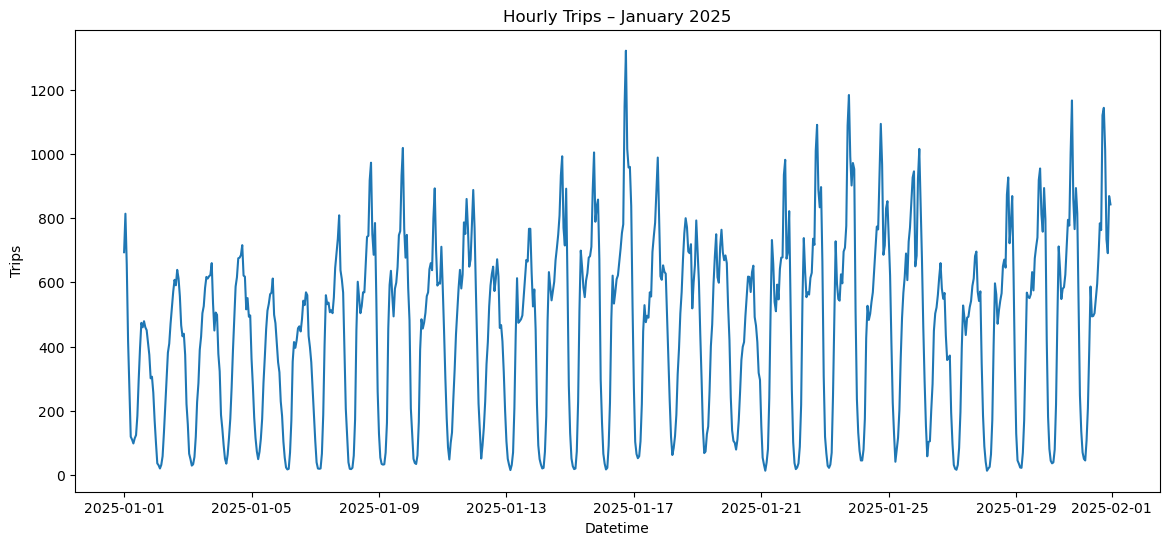

In [26]:
%matplotlib inline
plt.figure(figsize=(14,6))
plt.plot(january['Date & Time'], january['Trips'])
plt.xlabel('Datetime')
plt.ylabel('Trips')
plt.title('Hourly Trips – January 2025')
plt.show()

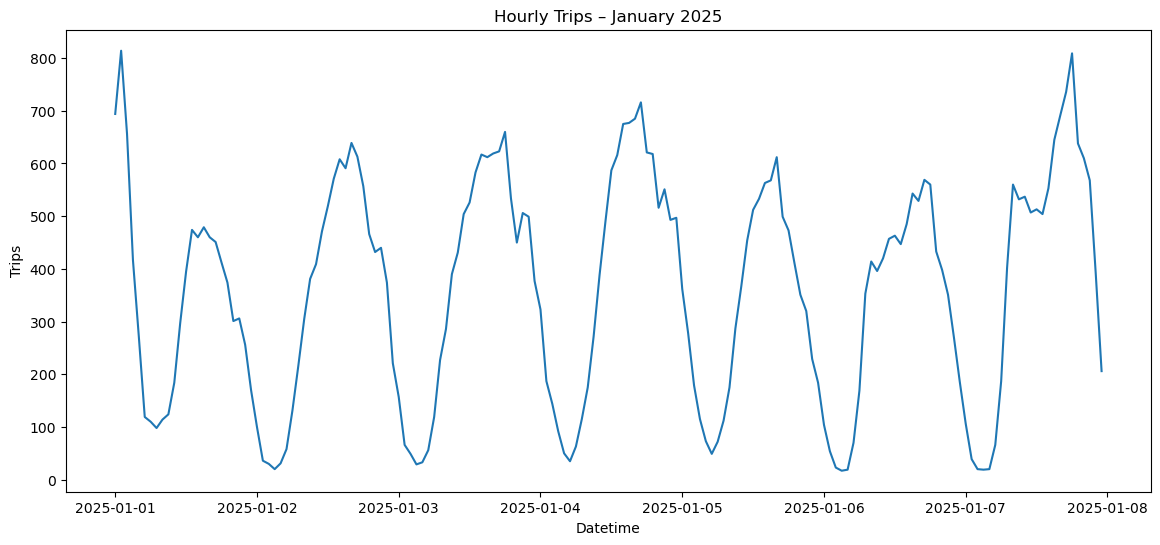

In [27]:
%matplotlib inline
plt.figure(figsize=(14,6))
plt.plot(week_1['Date & Time'], week_1['Trips'])
plt.xlabel('Datetime')
plt.ylabel('Trips')
plt.title('Hourly Trips – January 2025')
plt.show()

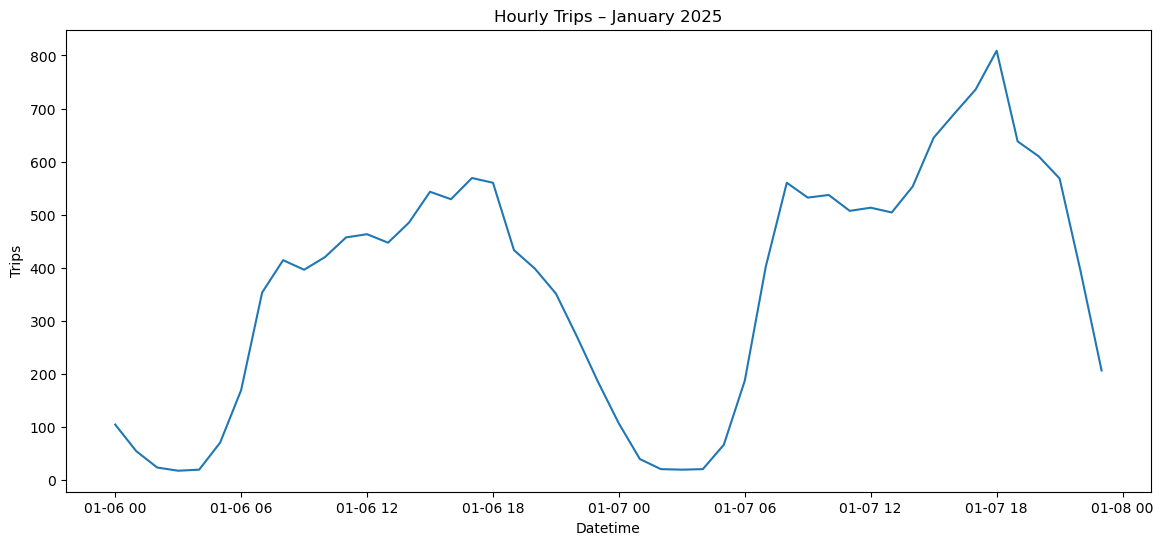

In [28]:
day_1 = week_1[week_1['Date'].dt.day>5]
%matplotlib inline
plt.figure(figsize=(14,6))
plt.plot(day_1['Date & Time'], day_1['Trips'])
plt.xlabel('Datetime')
plt.ylabel('Trips')
plt.title('Hourly Trips – January 2025')
plt.show()

In [29]:
resampling['naive_forecast'] = resampling['Trips'].shift(24)

In [30]:
resampling.dropna(inplace=True)

KeyError: 'naive_forecast'

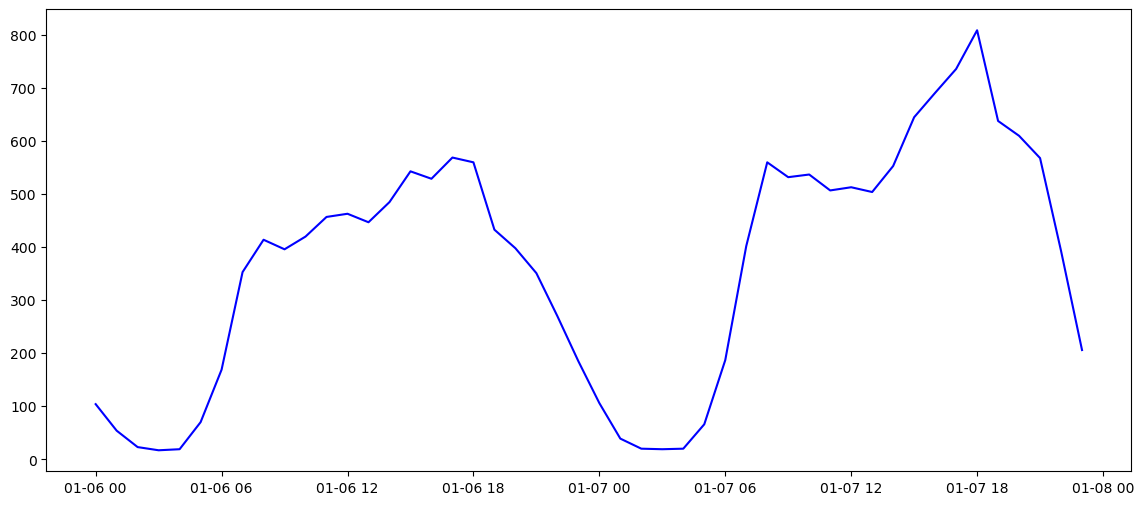

In [ ]:
# day_1 = week_1[week_1['Date'].dt.day>5]
# %matplotlib inline
# plt.figure(figsize=(14,6))
# plt.plot(day_1['Date & Time'], day_1['Trips'], label='Actual Trips',color='blue')
# plt.plot(day_1['Date & Time'], day_1['naive_forecast'], label='Naive Forecast',color='orange')
# plt.legend()

# plt.xlabel('Datetime')
# plt.ylabel('Trips')
# plt.title('Hourly Trips – January 2025')
# plt.show()

In [32]:
day_1

,Date,Hour,Trips,Date & Time
120,2025-01-06,0,104,2025-01-06 00:00:00
121,2025-01-06,1,54,2025-01-06 01:00:00
122,2025-01-06,2,23,2025-01-06 02:00:00
123,2025-01-06,3,17,2025-01-06 03:00:00
124,2025-01-06,4,19,2025-01-06 04:00:00
125,2025-01-06,5,70,2025-01-06 05:00:00
126,2025-01-06,6,169,2025-01-06 06:00:00
127,2025-01-06,7,353,2025-01-06 07:00:00
128,2025-01-06,8,414,2025-01-06 08:00:00
129,2025-01-06,9,396,2025-01-06 09:00:00


In [ ]:
resampling_data_for_sarimax = resampling.set_index('Date & Time')
resampling_data_for_sarimax

,Date,Hour,Trips,naive_forecast
Date & Time,,,,
2025-01-02 00:00:00,2025-01-02,0,100,694.0
2025-01-02 01:00:00,2025-01-02,1,36,814.0
2025-01-02 02:00:00,2025-01-02,2,30,656.0
2025-01-02 03:00:00,2025-01-02,3,20,417.0
2025-01-02 04:00:00,2025-01-02,4,31,271.0
...,...,...,...,...
2025-10-31 19:00:00,2025-10-31,19,1155,1017.0
2025-10-31 20:00:00,2025-10-31,20,1041,865.0
2025-10-31 21:00:00,2025-10-31,21,1089,954.0


In [ ]:
y = resampling_data_for_sarimax['Trips'].last('180D')

C:\Users\Shaaf\AppData\Local\Temp\ipykernel_18160\3067250169.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  y = resampling_data_for_sarimax['Trips'].last('180D')


In [ ]:
y

Date & Time
2025-05-05 00:00:00     221
2025-05-05 01:00:00     126
2025-05-05 02:00:00      48
2025-05-05 03:00:00      21
2025-05-05 04:00:00      42
                       ... 
2025-10-31 19:00:00    1155
2025-10-31 20:00:00    1041
2025-10-31 21:00:00    1089
2025-10-31 22:00:00    1072
2025-10-31 23:00:00    1047
Name: Trips, Length: 4320, dtype: int64

In [ ]:
pmdarima_model_order = auto_arima(y, seasonal=True, m=24, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True,start_p=1,start_q=1,max_p=3,max_q=3,start_P=0,start_Q=0,max_P=2,max_Q=2)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=51347.920, Time=0.98 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=61515.714, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=49608.007, Time=8.49 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=54079.378, Time=9.17 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=67944.697, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=52937.525, Time=0.12 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=49592.001, Time=47.12 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=70.95 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=49583.034, Time=11.33 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=50883.069, Time=4.30 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=49357.310, Time=56.54 sec
 ARIMA(1,0,0)(0,0,2)[24] intercept   : AIC=50191.499, Time=29.34 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=53.43 sec
 ARIMA(0,0,0)(1,0,2)[24] intercept   : AIC=56344.065, Time=40.01 sec
 ARIMA(2,0

In [ ]:
order_best=(2, 0, 0)
seasonal_order_best=(1, 0, 1, 24)

In [ ]:
pmdarima_model_order.order

(2, 0, 0)

In [ ]:
sarimax_model = SARIMAX(resampling_data_for_sarimax['Trips'], order=pmdarima_model_order.order, seasonal_order=pmdarima_model_order.seasonal_order)
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

c:\Users\Shaaf\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Shaaf\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Trips   No. Observations:                 7271
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 24)   Log Likelihood              -41294.693
Date:                              Fri, 19 Dec 2025   AIC                          82599.387
Time:                                      12:38:38   BIC                          82633.845
Sample:                                           0   HQIC                         82611.238
                                             - 7271                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1834      0.008    152.912      0.000       1.168       1.199
ar.L2         -0.3554      0.009    -40.872      0.000      -0.372      -0.338
ar.S.L24       0.9995      0.000   3763.716      0.000       0.999       1.000
ma.S.L24      -0.9385      0.003   -314.207      0.000      -0.944      -0.933
sigma2      4972.3308     51.724     96.132      0.000    4870.954    5073.708
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):              4033.95
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
resampling_data_for_sarimax['Fitted'] = sarimax_results.fittedvalues

In [ ]:
resampling_data_for_sarimax

,Date,Hour,Trips,naive_forecast,Fitted
Date & Time,,,,,
2025-01-02 00:00:00,2025-01-02,0,100,694.0,0.000000
2025-01-02 01:00:00,2025-01-02,1,36,814.0,87.315905
2025-01-02 02:00:00,2025-01-02,2,30,656.0,7.069692
2025-01-02 03:00:00,2025-01-02,3,20,417.0,22.712662
2025-01-02 04:00:00,2025-01-02,4,31,271.0,13.012630
...,...,...,...,...,...
2025-10-31 19:00:00,2025-10-31,19,1155,1017.0,1014.425583
2025-10-31 20:00:00,2025-10-31,20,1041,865.0,1077.104458
2025-10-31 21:00:00,2025-10-31,21,1089,954.0,1006.828380


In [ ]:
resampling_data_for_sarimax['abs_error'] = abs(resampling_data_for_sarimax['Trips'] - resampling_data_for_sarimax['Fitted'])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error

In [ ]:
mae_sarimax =mean_absolute_error(resampling_data_for_sarimax['Trips'], resampling_data_for_sarimax['Fitted'])
mse_sarimax =mean_squared_error(resampling_data_for_sarimax['Trips'], resampling_data_for_sarimax['Fitted'])
rmse_sarimax =root_mean_squared_error(resampling_data_for_sarimax['Trips'], resampling_data_for_sarimax['Fitted'])
print(f"SARIMAX Model - MAE: {mae_sarimax}, MSE: {mse_sarimax}, RMSE: {rmse_sarimax}")

SARIMAX Model - MAE: 50.64312485391504, MSE: 4997.24354654734, RMSE: 70.69118436231875


In [ ]:
sarimax_january = resampling_data_for_sarimax[resampling_data_for_sarimax.index.month==1]
sarimax_january

,Date,Hour,Trips,naive_forecast,Fitted
Date & Time,,,,,
2025-01-02 00:00:00,2025-01-02,0,100,694.0,0.000000
2025-01-02 01:00:00,2025-01-02,1,36,814.0,87.315905
2025-01-02 02:00:00,2025-01-02,2,30,656.0,7.069692
2025-01-02 03:00:00,2025-01-02,3,20,417.0,22.712662
2025-01-02 04:00:00,2025-01-02,4,31,271.0,13.012630
...,...,...,...,...,...
2025-01-31 19:00:00,2025-01-31,19,1013,861.0,926.874482
2025-01-31 20:00:00,2025-01-31,20,734,766.0,893.341701
2025-01-31 21:00:00,2025-01-31,21,691,894.0,692.320147


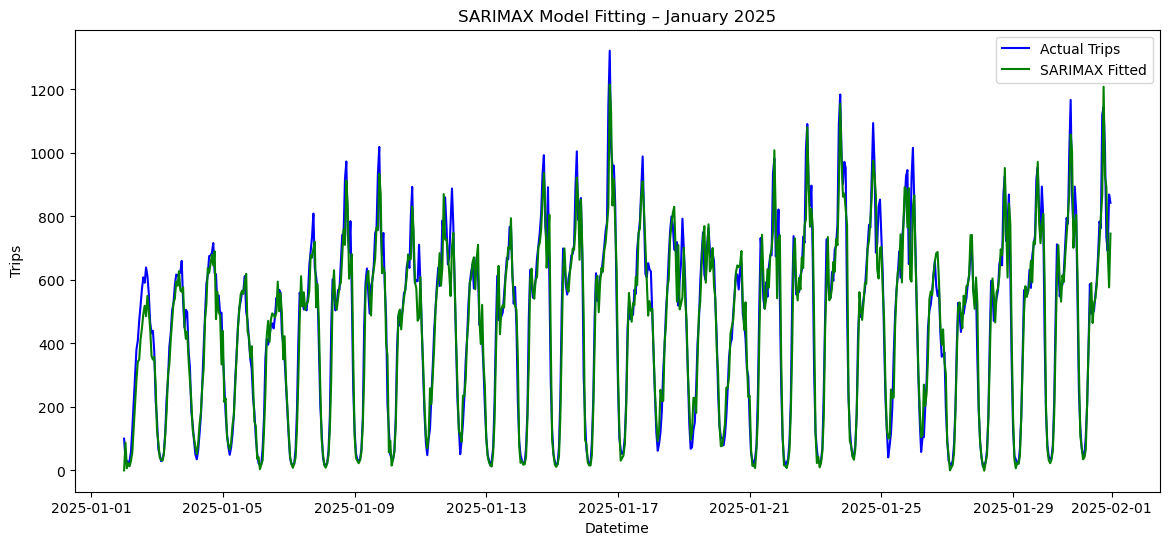

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(sarimax_january.index, sarimax_january['Trips'], label='Actual Trips', color='blue')
plt.plot(sarimax_january.index, sarimax_january['Fitted'], label='SARIMAX Fitted', color='green')
plt.xlabel('Datetime')
plt.ylabel('Trips')
plt.title('SARIMAX Model Fitting – January 2025')
plt.legend()
plt.show()

In [ ]:
sarimax_week_1 = sarimax_january[sarimax_january.index.day<=7]
sarimax_week_1

,Date,Hour,Trips,naive_forecast,Fitted
Date & Time,,,,,
2025-01-02 00:00:00,2025-01-02,0,100,694.0,0.000000
2025-01-02 01:00:00,2025-01-02,1,36,814.0,87.315905
2025-01-02 02:00:00,2025-01-02,2,30,656.0,7.069692
2025-01-02 03:00:00,2025-01-02,3,20,417.0,22.712662
2025-01-02 04:00:00,2025-01-02,4,31,271.0,13.012630
...,...,...,...,...,...
2025-01-07 19:00:00,2025-01-07,19,638,433.0,720.237133
2025-01-07 20:00:00,2025-01-07,20,610,398.0,513.707016
2025-01-07 21:00:00,2025-01-07,21,568,351.0,586.840786


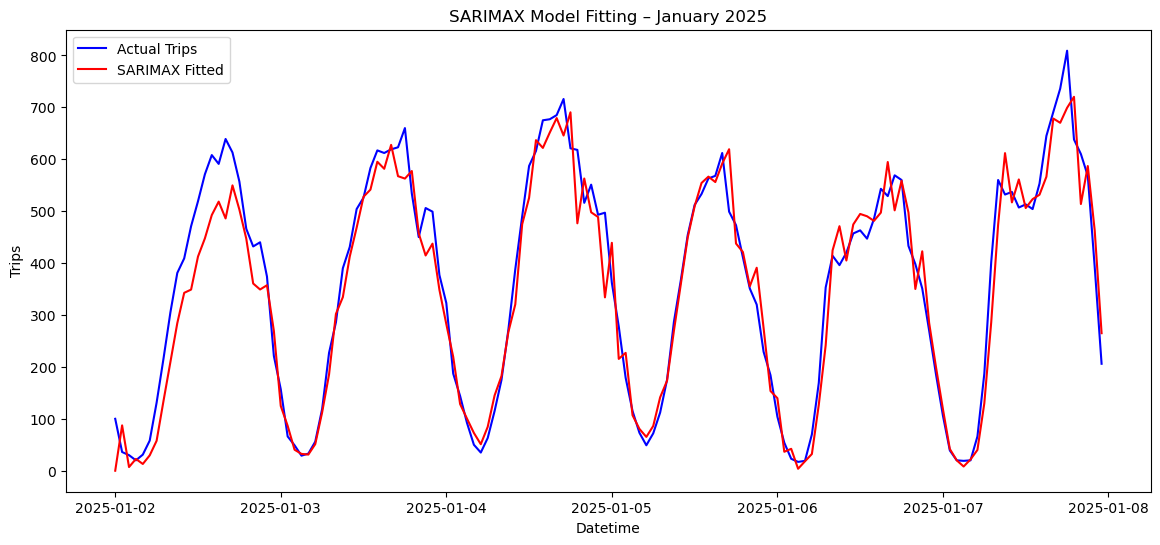

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(sarimax_week_1.index, sarimax_week_1['Trips'], label='Actual Trips', color='blue')
plt.plot(sarimax_week_1.index, sarimax_week_1['Fitted'], label='SARIMAX Fitted', color='red')
plt.xlabel('Datetime')
plt.ylabel('Trips')
plt.title('SARIMAX Model Fitting – January 2025')
plt.legend()
plt.show()

In [ ]:
resampling_data_for_sarimax

,Date,Hour,Trips,naive_forecast,Fitted,abs_error
Date & Time,,,,,,
2025-01-02 00:00:00,2025-01-02,0,100,694.0,0.000000,100.000000
2025-01-02 01:00:00,2025-01-02,1,36,814.0,87.315905,51.315905
2025-01-02 02:00:00,2025-01-02,2,30,656.0,7.069692,22.930308
2025-01-02 03:00:00,2025-01-02,3,20,417.0,22.712662,2.712662
2025-01-02 04:00:00,2025-01-02,4,31,271.0,13.012630,17.987370
...,...,...,...,...,...,...
2025-10-31 19:00:00,2025-10-31,19,1155,1017.0,1014.425583,140.574417
2025-10-31 20:00:00,2025-10-31,20,1041,865.0,1077.104458,36.104458
2025-10-31 21:00:00,2025-10-31,21,1089,954.0,1006.828380,82.171620


In [ ]:
prophet_data = (resampling_data_for_sarimax.reset_index())

In [ ]:
prophet_data

,Date & Time,Date,Hour,Trips,naive_forecast,Fitted,abs_error
0,2025-01-02 00:00:00,2025-01-02,0,100,694.0,0.000000,100.000000
1,2025-01-02 01:00:00,2025-01-02,1,36,814.0,87.315905,51.315905
2,2025-01-02 02:00:00,2025-01-02,2,30,656.0,7.069692,22.930308
3,2025-01-02 03:00:00,2025-01-02,3,20,417.0,22.712662,2.712662
4,2025-01-02 04:00:00,2025-01-02,4,31,271.0,13.012630,17.987370
...,...,...,...,...,...,...,...
7266,2025-10-31 19:00:00,2025-10-31,19,1155,1017.0,1014.425583,140.574417
7267,2025-10-31 20:00:00,2025-10-31,20,1041,865.0,1077.104458,36.104458
7268,2025-10-31 21:00:00,2025-10-31,21,1089,954.0,1006.828380,82.171620
7269,2025-10-31 22:00:00,2025-10-31,22,1072,903.0,990.918500,81.081500


In [ ]:
prophet_data = prophet_data[['Date & Time','Trips']]

In [ ]:
prophet_data=prophet_data.rename(columns={'Date & Time':'ds','Trips':'y'})

In [ ]:
from prophet import Prophet

In [ ]:
prophet_data

,ds,y
0,2025-01-02 00:00:00,100
1,2025-01-02 01:00:00,36
2,2025-01-02 02:00:00,30
3,2025-01-02 03:00:00,20
4,2025-01-02 04:00:00,31
...,...,...
7266,2025-10-31 19:00:00,1155
7267,2025-10-31 20:00:00,1041
7268,2025-10-31 21:00:00,1089
7269,2025-10-31 22:00:00,1072


In [ ]:
prophet_model = Prophet(daily_seasonality=True,weekly_seasonality=True,yearly_seasonality=False)

In [ ]:
print(prophet_data['y'].describe())
print(prophet_data['y'].isna().sum())  # Check for NaN values
print((prophet_data['y'] <= 0).sum()) 

count    7271.000000
mean      541.132444
std       301.478515
min        12.000000
25%       258.000000
50%       598.000000
75%       752.000000
max      1400.000000
Name: y, dtype: float64
0
0


In [ ]:
prophet_data.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [ ]:
prophet_data.describe()

,ds,y
count,7271,7271.000000
mean,2025-06-02 11:46:54.743501824,541.132444
min,2025-01-02 00:00:00,12.000000
25%,2025-03-18 18:30:00,258.000000
50%,2025-06-02 12:00:00,598.000000
75%,2025-08-17 05:30:00,752.000000
max,2025-10-31 23:00:00,1400.000000
std,NaN,301.478515


In [ ]:
prophet_model = Prophet(
    changepoint_prior_scale=0.05,  # Controls flexibility of trend
    seasonality_prior_scale=1.0,    # Controls flexibility of seasonality
    seasonality_mode='multiplicative',  # Often better for data with varying amplitude
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,  # You only have 1 year of data
    interval_width=0.95
)

In [ ]:
model_path = r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\models\prophet_model.pkl"

In [ ]:
import pickle
with open(model_path, "rb") as f:
    prophet_model = pickle.load(f)

In [ ]:
prophet_model

In [ ]:
future = prophet_model.make_future_dataframe(periods=0,freq='H')

c:\Users\Shaaf\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [ ]:
future

,ds
0,2025-01-02 00:00:00
1,2025-01-02 01:00:00
2,2025-01-02 02:00:00
3,2025-01-02 03:00:00
4,2025-01-02 04:00:00
...,...
7266,2025-10-31 19:00:00
7267,2025-10-31 20:00:00
7268,2025-10-31 21:00:00
7269,2025-10-31 22:00:00


In [ ]:
prophet_forecast = prophet_model.predict(future)

In [ ]:
df_compare = resampling_data_for_sarimax.copy()

In [ ]:
df_compare['prophet_fitted'] = prophet_forecast['yhat'].values
df_compare['sarimax_fitted'] = sarimax_results.fittedvalues

In [ ]:
df_compare.dtypes

Date              datetime64[ns]
Hour                       int32
Trips                      int64
naive_forecast           float64
Fitted                   float64
abs_error                float64
prophet_fitted           float64
sarimax_fitted           float64
dtype: object

In [ ]:
df_compare

,Date,Hour,Trips,naive_forecast,Fitted,abs_error,prophet_fitted,sarimax_fitted
Date & Time,,,,,,,,
2025-01-02 00:00:00,2025-01-02,0,100,694.0,0.000000,100.000000,358.873738,0.000000
2025-01-02 01:00:00,2025-01-02,1,36,814.0,87.315905,51.315905,251.742662,87.315905
2025-01-02 02:00:00,2025-01-02,2,30,656.0,7.069692,22.930308,159.087676,7.069692
2025-01-02 03:00:00,2025-01-02,3,20,417.0,22.712662,2.712662,101.600067,22.712662
2025-01-02 04:00:00,2025-01-02,4,31,271.0,13.012630,17.987370,93.209106,13.012630
...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,2025-10-31,19,1155,1017.0,1014.425583,140.574417,1017.072571,1014.425583
2025-10-31 20:00:00,2025-10-31,20,1041,865.0,1077.104458,36.104458,982.727553,1077.104458
2025-10-31 21:00:00,2025-10-31,21,1089,954.0,1006.828380,82.171620,923.410530,1006.828380


In [ ]:
data_comaparision = df_compare[df_compare['Date'].dt.month==1]


In [ ]:
data_comaparision

,Date,Hour,Trips,naive_forecast,Fitted,abs_error,prophet_fitted,sarimax_fitted
Date & Time,,,,,,,,
2025-01-02 00:00:00,2025-01-02,0,100,694.0,0.000000,100.000000,358.873738,0.000000
2025-01-02 01:00:00,2025-01-02,1,36,814.0,87.315905,51.315905,251.742662,87.315905
2025-01-02 02:00:00,2025-01-02,2,30,656.0,7.069692,22.930308,159.087676,7.069692
2025-01-02 03:00:00,2025-01-02,3,20,417.0,22.712662,2.712662,101.600067,22.712662
2025-01-02 04:00:00,2025-01-02,4,31,271.0,13.012630,17.987370,93.209106,13.012630
...,...,...,...,...,...,...,...,...
2025-01-31 19:00:00,2025-01-31,19,1013,861.0,926.874482,86.125518,849.479349,926.874482
2025-01-31 20:00:00,2025-01-31,20,734,766.0,893.341701,159.341701,820.813361,893.341701
2025-01-31 21:00:00,2025-01-31,21,691,894.0,692.320147,1.320147,771.287878,692.320147


In [ ]:
data_comaparision=data_comaparision[data_comaparision['Date'].dt.day<=7]

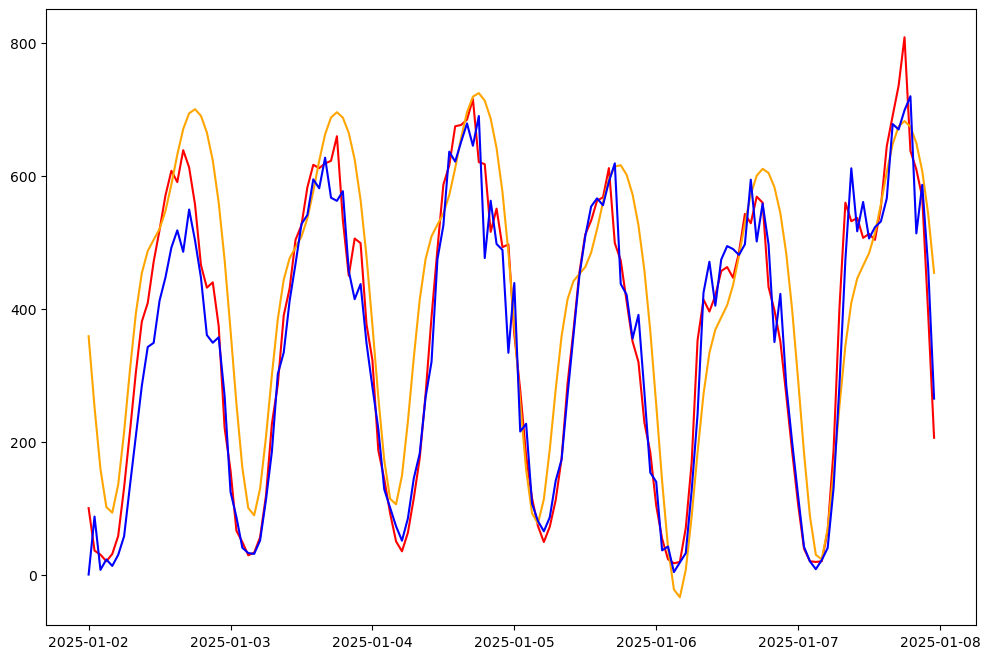

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(data_comaparision.index,data_comaparision['Trips'],color='red')
plt.plot(data_comaparision.index,data_comaparision['prophet_fitted'],color='orange')
plt.plot(data_comaparision.index,data_comaparision['sarimax_fitted'],color='blue')
plt.show()

In [ ]:
import numpy as np
mae_prophet = mean_absolute_error(df_compare['Trips'], df_compare['prophet_fitted'])
mse_prophet = mean_squared_error(df_compare['Trips'], df_compare['prophet_fitted'])
rmse_prophet = np.sqrt(mse_prophet)

In [ ]:
print("Prophet MAE", f"{mae_prophet:.2f}")
print("Prophet MSE", f"{mse_prophet:.2f}")
print(f"prophet rmse {rmse_prophet:.2f}")



Prophet MAE 107.80
Prophet MSE 19341.38
prophet rmse 139.07


In [ ]:
import xgboost

In [33]:
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,Date,Hour
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,0.5,5.45,0.0,1.0,32.75,2.5,0.0,0.00,2025-01-08,12
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,NaN,1.26,NaN,None,41,75,0,...,0.5,3.02,0.0,1.0,18.10,NaN,NaN,0.00,2025-01-12,15
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,0.5,0.00,0.0,1.0,18.25,2.5,0.0,0.75,2025-01-22,10
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,0.5,0.00,0.0,1.0,17.95,2.5,0.0,0.75,2025-01-21,19
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,0.5,2.82,0.0,1.0,12.22,0.0,0.0,0.00,2025-01-17,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023615,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,0.5,2.30,0.0,1.0,13.85,2.5,0.0,0.75,2025-10-26,21
4023616,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,0.5,0.00,0.0,1.0,9.80,2.5,0.0,0.00,2025-10-04,12
4023617,2,2025-10-21 20:24:52,2025-10-21 21:02:30,NaN,6.68,NaN,None,107,238,0,...,0.5,0.00,0.0,1.0,7.23,NaN,NaN,0.75,2025-10-21,20
4023618,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,0.5,4.12,0.0,1.0,24.72,0.0,0.0,0.00,2025-10-04,15


In [34]:
(data['passenger_count'].isnull().sum())/len(data)

0.23616982964790859

In [ ]:
data.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
cbd_congestion_fee       0
Date                     0
Hour                     0
dtype: int64

In [35]:
data['passenger_count'].fillna(0, inplace=True)
data['RatecodeID'].fillna(-1, inplace=True)
data['store_and_fwd_flag'].fillna('N', inplace=True)
data['congestion_surcharge'].fillna(0, inplace=True)
data['Airport_fee'].fillna(0, inplace=True)

C:\Users\Shaaf\AppData\Local\Temp\ipykernel_28440\112378267.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['passenger_count'].fillna(0, inplace=True)
C:\Users\Shaaf\AppData\Local\Temp\ipykernel_28440\112378267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['passenger_count'].fillna(0, inplace=True)
C:\Users\Shaaf\AppData\Lo

In [36]:
# %pip install meteostat

from meteostat import Point, Hourly

In [37]:
data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,Date,Hour
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,0.5,5.45,0.0,1.0,32.75,2.5,0.0,0.00,2025-01-08,12
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,...,0.5,3.02,0.0,1.0,18.10,0.0,0.0,0.00,2025-01-12,15
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,0.5,0.00,0.0,1.0,18.25,2.5,0.0,0.75,2025-01-22,10
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,0.5,0.00,0.0,1.0,17.95,2.5,0.0,0.75,2025-01-21,19
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,0.5,2.82,0.0,1.0,12.22,0.0,0.0,0.00,2025-01-17,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023615,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,0.5,2.30,0.0,1.0,13.85,2.5,0.0,0.75,2025-10-26,21
4023616,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,0.5,0.00,0.0,1.0,9.80,2.5,0.0,0.00,2025-10-04,12
4023617,2,2025-10-21 20:24:52,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,...,0.5,0.00,0.0,1.0,7.23,0.0,0.0,0.75,2025-10-21,20
4023618,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,0.5,4.12,0.0,1.0,24.72,0.0,0.0,0.00,2025-10-04,15


In [38]:
location = Point(40.7128, -74.0060)  # NYC example
weather = Hourly(
    location,
    start=data['Date'].min(),
    end=data['Date'].max()
).fetch().reset_index()

weather = weather[['time', 'temp', 'prcp', 'wspd']]
weather.rename(columns={'time': 'Date'}, inplace=True)

df = data.merge(weather, on='Date', how='left')

In [39]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,Date,Hour,temp,prcp,wspd
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,1.0,32.75,2.5,0.0,0.00,2025-01-08,12,-1.1,0.0,7.6
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,...,1.0,18.10,0.0,0.0,0.00,2025-01-12,15,0.0,0.0,0.0
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,1.0,18.25,2.5,0.0,0.75,2025-01-22,10,-7.8,0.0,18.4
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,1.0,17.95,2.5,0.0,0.75,2025-01-21,19,-5.6,0.0,20.5
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,1.0,12.22,0.0,0.0,0.00,2025-01-17,14,-1.7,0.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943005,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,1.0,13.85,2.5,0.0,0.75,2025-10-26,21,14.0,0.0,7.0
3943006,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,1.0,9.80,2.5,0.0,0.00,2025-10-04,12,18.0,0.0,11.0
3943007,2,2025-10-21 20:24:52,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,...,1.0,7.23,0.0,0.0,0.75,2025-10-21,20,15.0,0.0,17.0
3943008,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,1.0,24.72,0.0,0.0,0.00,2025-10-04,15,18.0,0.0,11.0


In [40]:
df['passenger_count'].fillna(0, inplace=True)
df['RatecodeID'].fillna(-1, inplace=True)
df['store_and_fwd_flag'].fillna('N', inplace=True)
df['congestion_surcharge'].fillna(0, inplace=True)
df['Airport_fee'].fillna(0, inplace=True)


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [41]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee,Date,Hour,temp,prcp,wspd
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,1.0,32.75,2.5,0.0,0.00,2025-01-08,12,-1.1,0.0,7.6
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,...,1.0,18.10,0.0,0.0,0.00,2025-01-12,15,0.0,0.0,0.0
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,1.0,18.25,2.5,0.0,0.75,2025-01-22,10,-7.8,0.0,18.4
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,1.0,17.95,2.5,0.0,0.75,2025-01-21,19,-5.6,0.0,20.5
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,1.0,12.22,0.0,0.0,0.00,2025-01-17,14,-1.7,0.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943005,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,1.0,13.85,2.5,0.0,0.75,2025-10-26,21,14.0,0.0,7.0
3943006,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,1.0,9.80,2.5,0.0,0.00,2025-10-04,12,18.0,0.0,11.0
3943007,2,2025-10-21 20:24:52,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,...,1.0,7.23,0.0,0.0,0.75,2025-10-21,20,15.0,0.0,17.0
3943008,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,1.0,24.72,0.0,0.0,0.00,2025-10-04,15,18.0,0.0,11.0


In [42]:
import holidays

In [43]:
us_holidays = holidays.US(years=df['Date'].dt.year.unique())

In [44]:
df['is_holiday'] = df['Date'].isin(us_holidays).astype(int)

In [45]:
df['is_festive_window'] = 0

for holiday_date in us_holidays:
    festive_range = pd.date_range(
        start=pd.to_datetime(holiday_date) - pd.Timedelta(days=2),
        end=pd.to_datetime(holiday_date) + pd.Timedelta(days=2)
    )
    df.loc[df['Date'].isin(festive_range), 'is_festive_window'] = 1

In [ ]:
df


In [49]:
import requests

def get_nyc_weather(start, end):
    url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude=40.7128&longitude=-74.0060"
        f"&start_date={start}&end_date={end}"
        "&daily=temperature_2m_mean,precipitation_sum"
        "&timezone=America/New_York"
    )
    return requests.get(url).json()

weather_json = get_nyc_weather(
    df['Date'].min().strftime('%Y-%m-%d'),
    df['Date'].max().strftime('%Y-%m-%d')
)

In [50]:
weather_json

{'latitude': 40.738136,
 'longitude': -74.04254,
 'generationtime_ms': 15.153884887695312,
 'utc_offset_seconds': -18000,
 'timezone': 'America/New_York',
 'timezone_abbreviation': 'GMT-5',
 'elevation': 32.0,
 'daily_units': {'time': 'iso8601',
  'temperature_2m_mean': '°C',
  'precipitation_sum': 'mm'},
 'daily': {'time': ['2025-01-01',
   '2025-01-02',
   '2025-01-03',
   '2025-01-04',
   '2025-01-05',
   '2025-01-06',
   '2025-01-07',
   '2025-01-08',
   '2025-01-09',
   '2025-01-10',
   '2025-01-11',
   '2025-01-12',
   '2025-01-13',
   '2025-01-14',
   '2025-01-15',
   '2025-01-16',
   '2025-01-17',
   '2025-01-18',
   '2025-01-19',
   '2025-01-20',
   '2025-01-21',
   '2025-01-22',
   '2025-01-23',
   '2025-01-24',
   '2025-01-25',
   '2025-01-26',
   '2025-01-27',
   '2025-01-28',
   '2025-01-29',
   '2025-01-30',
   '2025-01-31',
   '2025-02-01',
   '2025-02-02',
   '2025-02-03',
   '2025-02-04',
   '2025-02-05',
   '2025-02-06',
   '2025-02-07',
   '2025-02-08',
   '2025-02-0

In [ ]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,congestion_surcharge,Airport_fee,cbd_congestion_fee,Date,Hour,temp,prcp,wspd,is_holiday,is_festive_window
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,2.5,0.0,0.00,2025-01-08,12,-1.1,0.0,7.6,0,0
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,...,0.0,0.0,0.00,2025-01-12,15,0.0,0.0,0.0,0,0
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,2.5,0.0,0.75,2025-01-22,10,-7.8,0.0,18.4,0,1
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,2.5,0.0,0.75,2025-01-21,19,-5.6,0.0,20.5,0,1
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,0.0,0.0,0.00,2025-01-17,14,-1.7,0.0,13.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943005,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,2.5,0.0,0.75,2025-10-26,21,14.0,0.0,7.0,0,0
3943006,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,2.5,0.0,0.00,2025-10-04,12,18.0,0.0,11.0,0,0
3943007,2,2025-10-21 20:24:52,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,...,0.0,0.0,0.75,2025-10-21,20,15.0,0.0,17.0,0,0
3943008,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,0.0,0.0,0.00,2025-10-04,15,18.0,0.0,11.0,0,0


In [51]:
weather_df = pd.DataFrame({
    'Date': pd.to_datetime(weather_json['daily']['time']),
    'avg_temp': weather_json['daily']['temperature_2m_mean'],
    'precipitation': weather_json['daily']['precipitation_sum']
})

In [52]:
weather_df

,Date,avg_temp,precipitation
0,2025-01-01,7.1,1.1
1,2025-01-02,2.4,0.0
2,2025-01-03,0.2,0.0
3,2025-01-04,-1.6,0.0
4,2025-01-05,-2.3,0.0
...,...,...,...
299,2025-10-27,7.9,0.0
300,2025-10-28,8.8,0.0
301,2025-10-29,10.3,0.1
302,2025-10-30,13.9,44.4


In [53]:
df = df.merge(weather_df, on='Date', how='left')

In [54]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,cbd_congestion_fee,Date,Hour,temp,prcp,wspd,is_holiday,is_festive_window,avg_temp,precipitation
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,0.00,2025-01-08,12,-1.1,0.0,7.6,0,0,-4.5,0.0
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,...,0.00,2025-01-12,15,0.0,0.0,0.0,0,0,0.5,0.0
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,0.75,2025-01-22,10,-7.8,0.0,18.4,0,1,-12.0,0.0
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,0.75,2025-01-21,19,-5.6,0.0,20.5,0,1,-11.4,0.4
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,0.00,2025-01-17,14,-1.7,0.0,13.0,0,0,-0.7,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943005,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,0.75,2025-10-26,21,14.0,0.0,7.0,0,0,10.0,0.1
3943006,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,0.00,2025-10-04,12,18.0,0.0,11.0,0,0,19.5,0.0
3943007,2,2025-10-21 20:24:52,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,...,0.75,2025-10-21,20,15.0,0.0,17.0,0,0,13.5,0.1
3943008,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,0.00,2025-10-04,15,18.0,0.0,11.0,0,0,19.5,0.0


In [55]:
df['is_rainy'] = (df['precipitation'] > 5).astype(int)
df['is_cold'] = (df['avg_temp'] < 5).astype(int)
df['is_hot'] = (df['avg_temp'] > 30).astype(int)

In [56]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,temp,prcp,wspd,is_holiday,is_festive_window,avg_temp,precipitation,is_rainy,is_cold,is_hot
0,1,2025-01-08 12:55:37,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,...,-1.1,0.0,7.6,0,0,-4.5,0.0,0,1,0
1,2,2025-01-12 15:08:16,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,...,0.0,0.0,0.0,0,0,0.5,0.0,0,1,0
2,2,2025-01-22 10:18:58,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,...,-7.8,0.0,18.4,0,1,-12.0,0.0,0,1,0
3,2,2025-01-21 19:36:32,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,...,-5.6,0.0,20.5,0,1,-11.4,0.4,0,1,0
4,2,2025-01-17 14:41:37,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,...,-1.7,0.0,13.0,0,0,-0.7,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943005,1,2025-10-26 21:24:08,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,...,14.0,0.0,7.0,0,0,10.0,0.1,0,0,0
3943006,1,2025-10-04 12:11:26,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,...,18.0,0.0,11.0,0,0,19.5,0.0,0,0,0
3943007,2,2025-10-21 20:24:52,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,...,15.0,0.0,17.0,0,0,13.5,0.1,0,0,0
3943008,2,2025-10-04 15:15:22,2025-10-04 15:31:20,2.0,3.39,1.0,N,65,255,1,...,18.0,0.0,11.0,0,0,19.5,0.0,0,0,0


In [ ]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee', 'Date', 'Hour', 'temp', 'prcp', 'wspd',
       'is_holiday', 'is_festive_window', 'avg_temp', 'precipitation',
       'is_rainy', 'is_cold', 'is_hot'],
      dtype='object')

In [ ]:
order_best=(2, 0, 0)
seasonal_order_best=(1, 0, 1, 24)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

In [ ]:
df = df.set_index('tpep_pickup_datetime')

In [58]:
df.to_parquet(r"C:\Users\Shaaf\Desktop\Data Science\Practice Projects\Transport Planning\Sampled_Data/data_with_exrogenous.parquet")

In [64]:
df

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,temp,prcp,wspd,is_holiday,is_festive_window,avg_temp,precipitation,is_rainy,is_cold,is_hot
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-08 12:55:37,1,2025-01-08 13:23:57,1.0,3.50,1.0,N,166,262,1,23.30,...,-1.1,0.0,7.6,0,0,-4.5,0.0,0,1,0
2025-01-12 15:08:16,2,2025-01-12 15:16:15,0.0,1.26,-1.0,N,41,75,0,13.58,...,0.0,0.0,0.0,0,0,0.5,0.0,0,1,0
2025-01-22 10:18:58,2,2025-01-22 10:32:20,2.0,1.73,1.0,N,164,144,4,13.50,...,-7.8,0.0,18.4,0,1,-12.0,0.0,0,1,0
2025-01-21 19:36:32,2,2025-01-21 19:46:12,1.0,1.47,1.0,N,107,186,2,10.70,...,-5.6,0.0,20.5,0,1,-11.4,0.4,0,1,0
2025-01-17 14:41:37,2,2025-01-17 14:47:38,1.0,0.81,1.0,N,75,74,1,7.90,...,-1.7,0.0,13.0,0,0,-0.7,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-26 21:24:08,1,2025-10-26 21:28:14,1.0,0.60,1.0,N,48,246,1,5.80,...,14.0,0.0,7.0,0,0,10.0,0.1,0,0,0
2025-10-04 12:11:26,1,2025-10-04 12:15:45,1.0,0.80,1.0,N,237,263,2,5.80,...,18.0,0.0,11.0,0,0,19.5,0.0,0,0,0
2025-10-21 20:24:52,2,2025-10-21 21:02:30,0.0,6.68,-1.0,N,107,238,0,-2.88,...,15.0,0.0,17.0,0,0,13.5,0.1,0,0,0


In [63]:
df.set_index('tpep_pickup_datetime',inplace=True)

In [65]:
sarimax_df = df.resample('H').agg({
    'VendorID': 'count',        # trips per hour
    'temp': 'mean',
    'prcp': 'mean',
    'wspd': 'mean',
    'is_holiday': 'max',
    'is_festive_window': 'max',
    'is_rainy': 'max',
    'is_cold': 'max',
    'is_hot': 'max'
})

In [66]:
sarimax_df

,VendorID,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot
tpep_pickup_datetime,,,,,,,,,
2025-01-01 00:00:00,694,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 01:00:00,814,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 02:00:00,656,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 03:00:00,417,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 04:00:00,271,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,1155,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0
2025-10-31 20:00:00,1041,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0
2025-10-31 21:00:00,1089,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0


In [67]:
sarimax_df = sarimax_df.rename(columns={'VendorID': 'Trips'})

In [68]:
y = sarimax_df['Trips']

In [69]:
exog_cols = [
    'temp', 'prcp', 'wspd',
    'is_holiday', 'is_festive_window',
    'is_rainy', 'is_cold', 'is_hot'
]

X = sarimax_df[exog_cols]

In [70]:
print(y.shape)
print(X.shape)
print(y.index.equals(X.index))

(7296,)
(7296, 8)
True


In [71]:
y = pd.DataFrame(y)

In [72]:
y

,Trips
tpep_pickup_datetime,
2025-01-01 00:00:00,694
2025-01-01 01:00:00,814
2025-01-01 02:00:00,656
2025-01-01 03:00:00,417
2025-01-01 04:00:00,271
...,...
2025-10-31 19:00:00,1155
2025-10-31 20:00:00,1041
2025-10-31 21:00:00,1089


In [73]:
X

,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot
tpep_pickup_datetime,,,,,,,,
2025-01-01 00:00:00,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 01:00:00,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 02:00:00,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 03:00:00,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 04:00:00,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0
2025-10-31 20:00:00,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0
2025-10-31 21:00:00,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"X data infor{X.describe}")
print(f"y data infor{y.describe}")

X data infor<bound method NDFrame.describe of                       temp  prcp  wspd  is_holiday  is_festive_window  \
tpep_pickup_datetime                                                    
2025-01-01 00:00:00    9.0   0.0  28.0         1.0                1.0   
2025-01-01 01:00:00    9.0   0.0  28.0         1.0                1.0   
2025-01-01 02:00:00    9.0   0.0  28.0         1.0                1.0   
2025-01-01 03:00:00    9.0   0.0  28.0         1.0                1.0   
2025-01-01 04:00:00    9.0   0.0  28.0         1.0                1.0   
...                    ...   ...   ...         ...                ...   
2025-10-31 19:00:00   17.0   2.3   9.0         0.0                0.0   
2025-10-31 20:00:00   17.0   2.3   9.0         0.0                0.0   
2025-10-31 21:00:00   17.0   2.3   9.0         0.0                0.0   
2025-10-31 22:00:00   17.0   2.3   9.0         0.0                0.0   
2025-10-31 23:00:00   17.0   2.3   9.0         0.0                0.0   

    

In [ ]:
print("Data types in X:")
print(X.dtypes)
print("\n")


Data types in X:
temp                 Float64
prcp                 Float64
wspd                 Float64
is_holiday           float64
is_festive_window    float64
is_rainy             float64
is_cold              float64
is_hot               float64
dtype: object




In [ ]:
y = pd.DataFrame(y)

In [ ]:
y.reset_index(inplace=True)

In [ ]:
y['tpep_pickup_datetime']=pd.to_datetime(y['tpep_pickup_datetime'])

In [ ]:
y.dtypes

tpep_pickup_datetime    datetime64[us]
Trips                            int64
dtype: object

In [ ]:
y.set_index('tpep_pickup_datetime',inplace=True)

In [ ]:
y.isnull().sum()

Trips    0
dtype: int64

In [79]:
X.fillna(0,inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [80]:
X.isnull().sum()

temp                 0
prcp                 0
wspd                 0
is_holiday           0
is_festive_window    0
is_rainy             0
is_cold              0
is_hot               0
dtype: int64

In [81]:
y.dtypes

Trips    int64
dtype: object

In [82]:
from sklearn.preprocessing import LabelEncoder

In [83]:
X_encoded = X.copy()

In [84]:
object_cols = X_encoded.select_dtypes(include=['object']).columns

In [85]:
for col in object_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

# Ensure all columns are float
X_encoded = X_encoded.astype(float)

In [86]:
sarimax_model = SARIMAX(
    y['Trips'],
    exog=X_encoded,
    order=(2, 0, 0),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

In [87]:
sarimax_results = sarimax_model.fit(disp=False)

In [ ]:
sarimax_df

,Trips,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot
tpep_pickup_datetime,,,,,,,,,
2025-01-01 00:00:00,694,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 01:00:00,814,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 02:00:00,656,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 03:00:00,417,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
2025-01-01 04:00:00,271,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,1155,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0
2025-10-31 20:00:00,1041,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0
2025-10-31 21:00:00,1089,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0


In [88]:
sarimax_df['Fitted Values Sarimax']=sarimax_results.fittedvalues

In [89]:
sarimax_df

,Trips,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot,Fitted Values Sarimax
tpep_pickup_datetime,,,,,,,,,,
2025-01-01 00:00:00,694,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,-159.045861
2025-01-01 01:00:00,814,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,860.494735
2025-01-01 02:00:00,656,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,711.974726
2025-01-01 03:00:00,417,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,482.068727
2025-01-01 04:00:00,271,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,250.494437
...,...,...,...,...,...,...,...,...,...,...
2025-10-31 19:00:00,1155,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1042.033278
2025-10-31 20:00:00,1041,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1103.275678
2025-10-31 21:00:00,1089,17.0,2.3,9.0,0.0,0.0,0.0,0.0,0.0,1025.275843


In [90]:
month_1 = sarimax_df[sarimax_df.index.month == 1]

In [91]:
month_1

,Trips,temp,prcp,wspd,is_holiday,is_festive_window,is_rainy,is_cold,is_hot,Fitted Values Sarimax
tpep_pickup_datetime,,,,,,,,,,
2025-01-01 00:00:00,694,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,-159.045861
2025-01-01 01:00:00,814,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,860.494735
2025-01-01 02:00:00,656,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,711.974726
2025-01-01 03:00:00,417,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,482.068727
2025-01-01 04:00:00,271,9.0,0.0,28.0,1.0,1.0,0.0,0.0,0.0,250.494437
...,...,...,...,...,...,...,...,...,...,...
2025-01-31 19:00:00,1013,1.7,0.0,5.4,0.0,0.0,1.0,1.0,0.0,960.478750
2025-01-31 20:00:00,734,1.7,0.0,5.4,0.0,0.0,1.0,1.0,0.0,918.679662
2025-01-31 21:00:00,691,1.7,0.0,5.4,0.0,0.0,1.0,1.0,0.0,710.136013


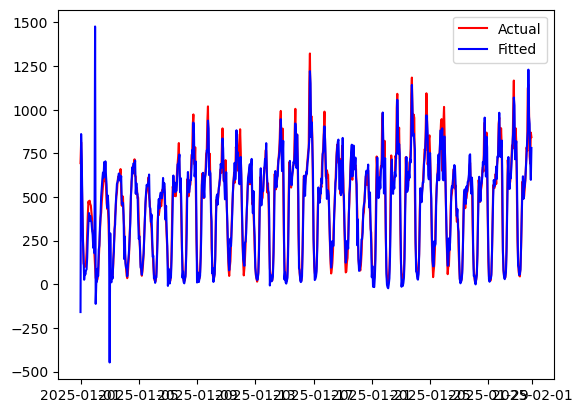

In [92]:
%matplotlib inline
plt.plot(month_1.index,month_1['Trips'],color='red',label='Actual')
plt.plot(month_1.index,month_1['Fitted Values Sarimax'],color='Blue',label='Fitted')
plt.legend()
plt.show()

In [93]:
sarimax_df['ABS Error'] = abs(sarimax_df['Trips'] - sarimax_df['Fitted Values Sarimax'])

In [94]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,root_mean_squared_error,r2_score

In [95]:
x_mae=mean_absolute_error(sarimax_df['Trips'],sarimax_df['Fitted Values Sarimax'])
x_mse = mean_squared_error(sarimax_df['Trips'],sarimax_df['Fitted Values Sarimax'])
x_rmse = root_mean_squared_error(sarimax_df['Trips'],sarimax_df['Fitted Values Sarimax'])
r2 = r2_score(sarimax_df['Trips'],sarimax_df['Fitted Values Sarimax'])

In [96]:
print(f"MAE {x_mae:.2f}")
print(f"MSE {x_mse:.2f}")
print(f"RMSE {x_rmse:.2f}")
print(f"r2_score {r2:.2f}")

MAE 54.50
MSE 6088.55
RMSE 78.03
r2_score 0.93
